In [24]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics
import re


In [2]:
#Data source: https://www.kaggle.com/datasets/gauthamp10/google-playstore-apps
data_folder = os.getcwd() +"/data/"
csv_name = "Google-Playstore.csv"
data_path = data_folder + csv_name

In [35]:
df = pd.read_csv(data_path)

In [36]:
#Feature engineering (eng) starts
eng_df = df.drop(['Installs', 'Currency', 'Minimum Installs', 'Developer Website', 'Developer Email', 'Privacy Policy', 'App Name'], axis=1)

#This one app had only 1 maximum install but an incredible number of ratings.
eng_df = eng_df[eng_df['App Id'] != 'com.google.android.apps.wellbeing']


# pak een n sample vd dataframe
eng_df_s = eng_df.sample(n=10000, random_state=123) #small
eng_df_t = eng_df.sample(n=1000, random_state=123) #tiny
eng_df_tt = eng_df.sample(n=200, random_state=123) #teeny-tiny

#Select one for further use
eng_df = eng_df_t

In [26]:
#What kind of Size values exist, going by the text part of the string
size_cats = eng_df_s['Size'].apply(lambda x: re.findall('([\sA-Za-z]*$)', str(x))[0])
print(size_cats.value_counts())

#Knowing there are three kinds of known sizes (kb, Mb, Gb) we convert these to Mb
#But because there are also missing values or OS dependent sizes, we store this categorically in an extra column
#(known sizes will be categorized as 'known')
def process_Size(value):
    value = str(value)
    conversion = {'k':0.001, 'M':1.0, 'G':1000.0}
    if value[-1] in conversion.keys():
        value = value.replace(',', '') #added because some 
        size = float(value[:-1]) * conversion[value[-1]]
        category = 'Known'
    else:
        size = None
        category = value
    return (size, category)


temp_df = pd.DataFrame(eng_df['Size'].apply(lambda x: process_Size(x)).tolist(), columns=['Size', 'Size_category'])
eng_df['Size'] = temp_df['Size'].values
eng_df['Size_category'] = temp_df['Size_category'].values
del temp_df

M                     9521
Varies with device     315
k                      164
Name: Size, dtype: int64


,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
198186,Digital Wellbeing,com.google.android.apps.wellbeing,Tools,4.1,396647.0,1+,1.0,1,True,0.0,...,https://wellbeing.google,digital-wellbeing-help@google.com,"Aug 8, 2018","Jun 15, 2021",Everyone,http://www.google.com/policies/privacy,False,False,False,2021-06-15 23:41:27


In [5]:
#Separate quantitative columns into a quantitative dataframe
q_columns = ['Rating', 'Rating Count', 'Maximum Installs', 'Price', 'Size']
cat_columns = eng_df.columns^q_columns
q_df = eng_df[q_columns]
cat_df = eng_df[cat_columns]

#Filter, e.g. based on quantitative variable outliers or category values
standard_deviations = 3
q_df_filter = q_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < standard_deviations).all(axis=1)
q_df = q_df[q_df_filter]
eng_df = eng_df[q_df_filter]
cat_df = cat_df[q_df_filter]

#Log-transform
#Needs to be edited so it's only applied to some columns (e.g. installs but not rating)
transf_q_df = q_df.apply(lambda x: np.log10(x, where=0.1<x))

C:\Users\~LarsSpekschoorTrain\AppData\Local\Temp\ipykernel_15020\2504945521.py:3: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  cat_columns = eng_df.columns^q_columns


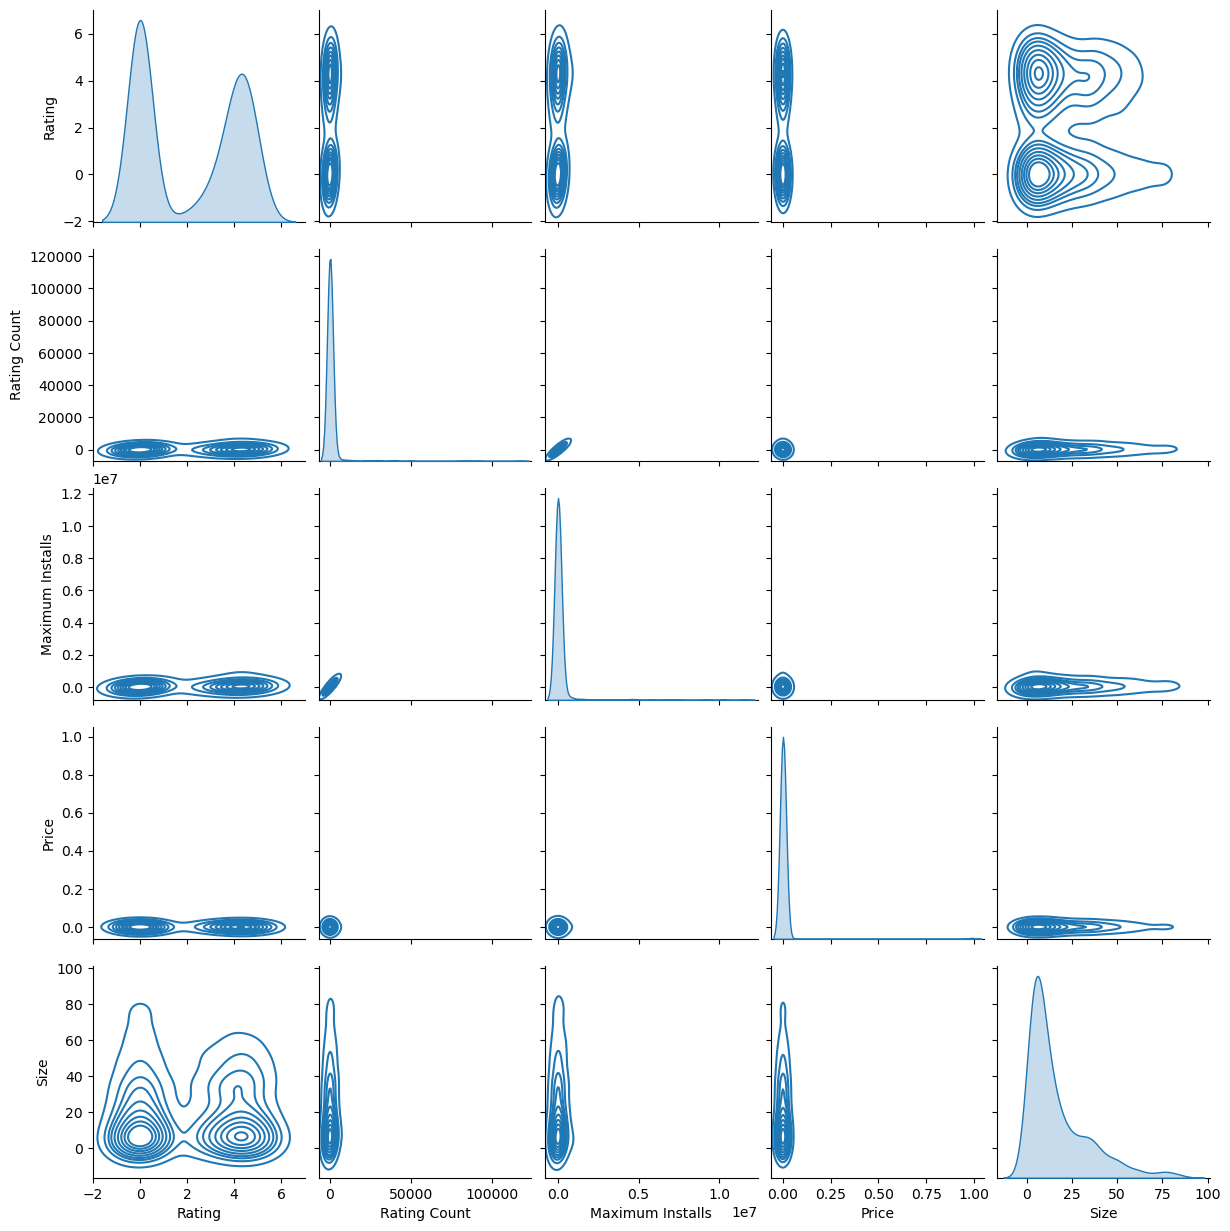

In [12]:
sns.pairplot(q_df, kind='kde')

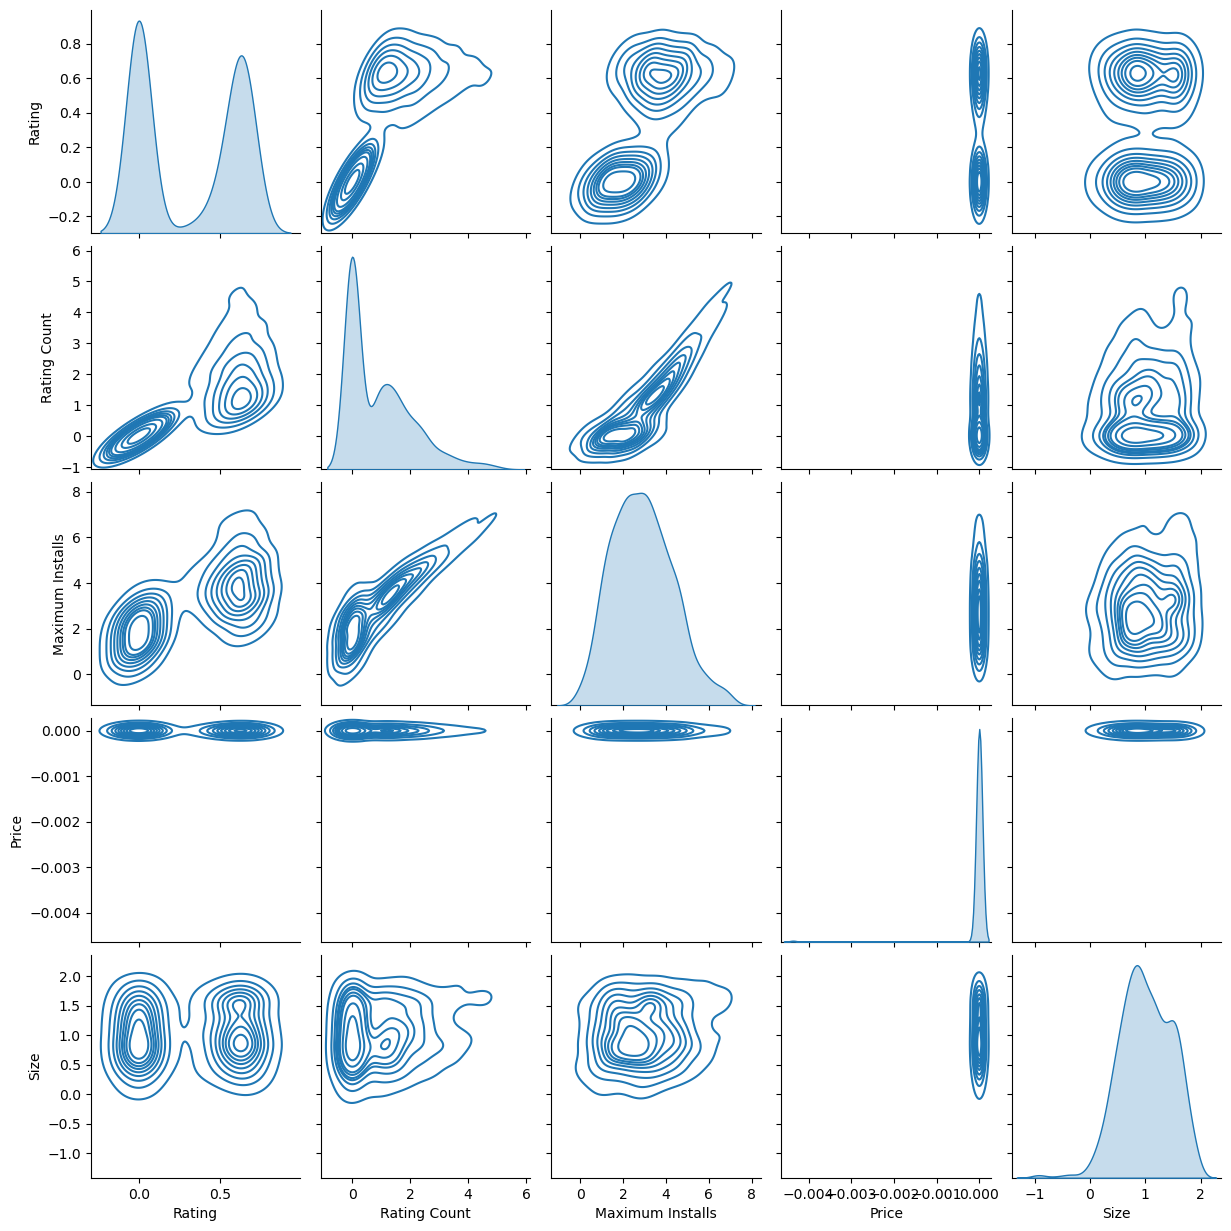

In [6]:
sns.pairplot(transf_q_df, kind="kde")
#One by one alternative: sns.distplot(col1, col2)

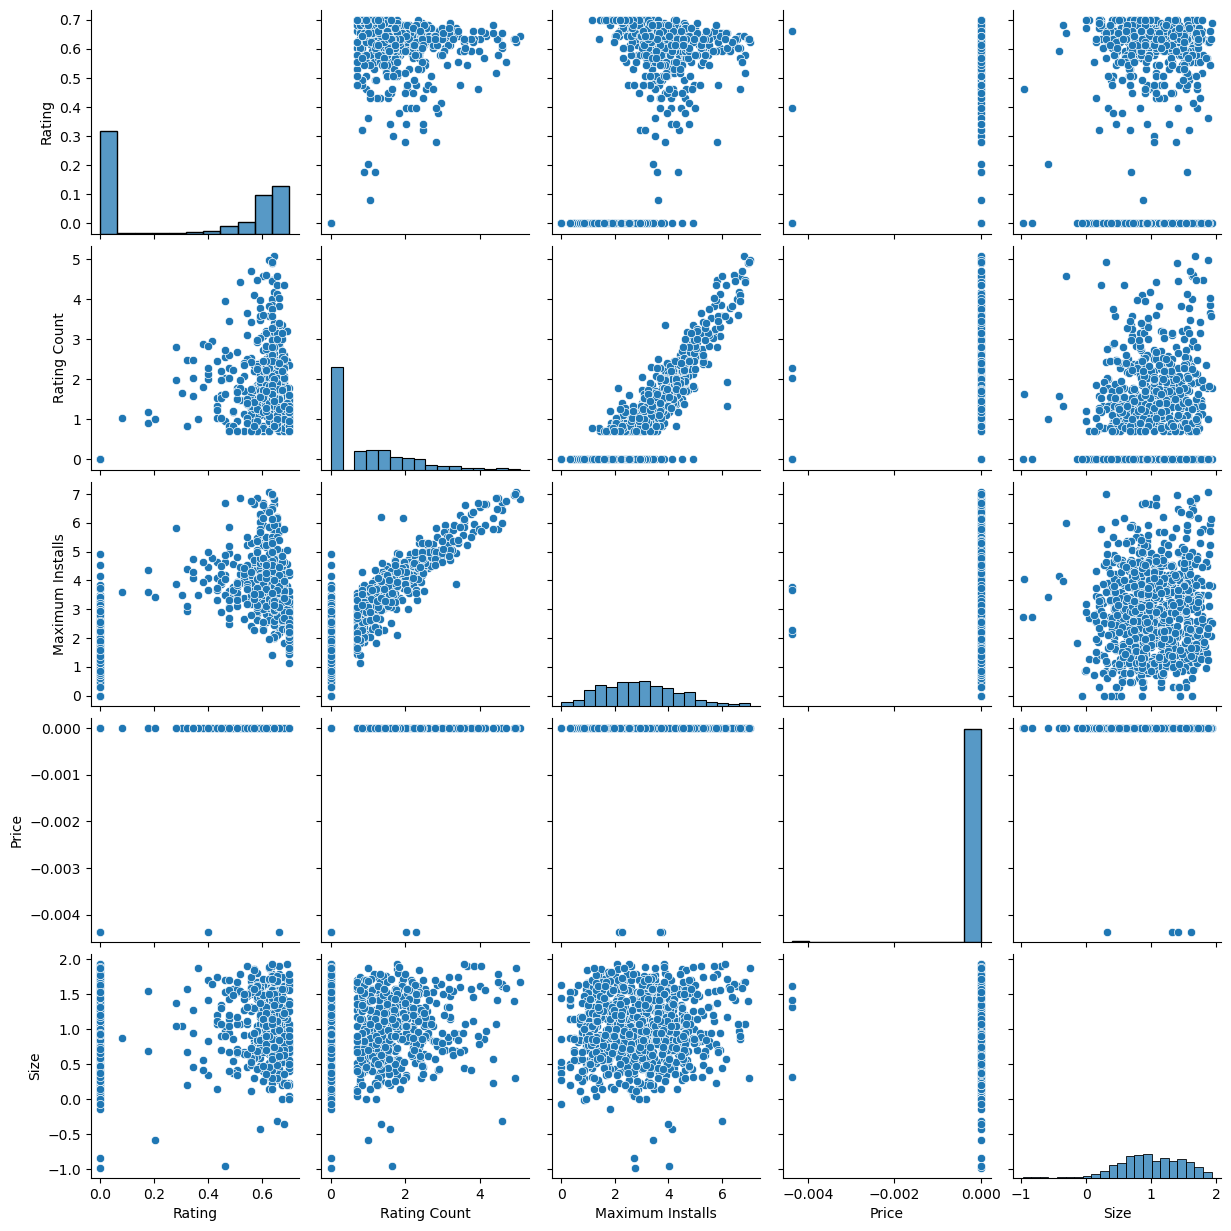

In [13]:
#Only run this with sufficiently small sample
sns.pairplot(transf_q_df)

In [20]:
eng_df['Size_category'].value_counts()

Known    938
Name: Size_category, dtype: int64

In [8]:
#PCA to see if a) quantitative variables combined show some clustering and b) wether such clusters correspond to categorical variables
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(q_df)
scaled_qdf = scaler.transform(q_df)

pca = PCA(n_components=q_df.shape[1])
pca.fit(scaled_qdf)

x_pca = pca.transform(scaled_qdf)
print(scaled_qdf.shape)
print(x_pca.shape)

(938, 5)
(938, 5)


Ad Supported unique values:  2
App Id unique values:  938
Category unique values:  48
Content Rating unique values:  4


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


Developer Id unique values:  925
Editors Choice unique values:  1
Free unique values:  2


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


In App Purchases unique values:  2
Last Updated unique values:  623
Minimum Android unique values:  25
Released unique values:  729
Scraped Time unique values:  926
Size_category unique values:  1


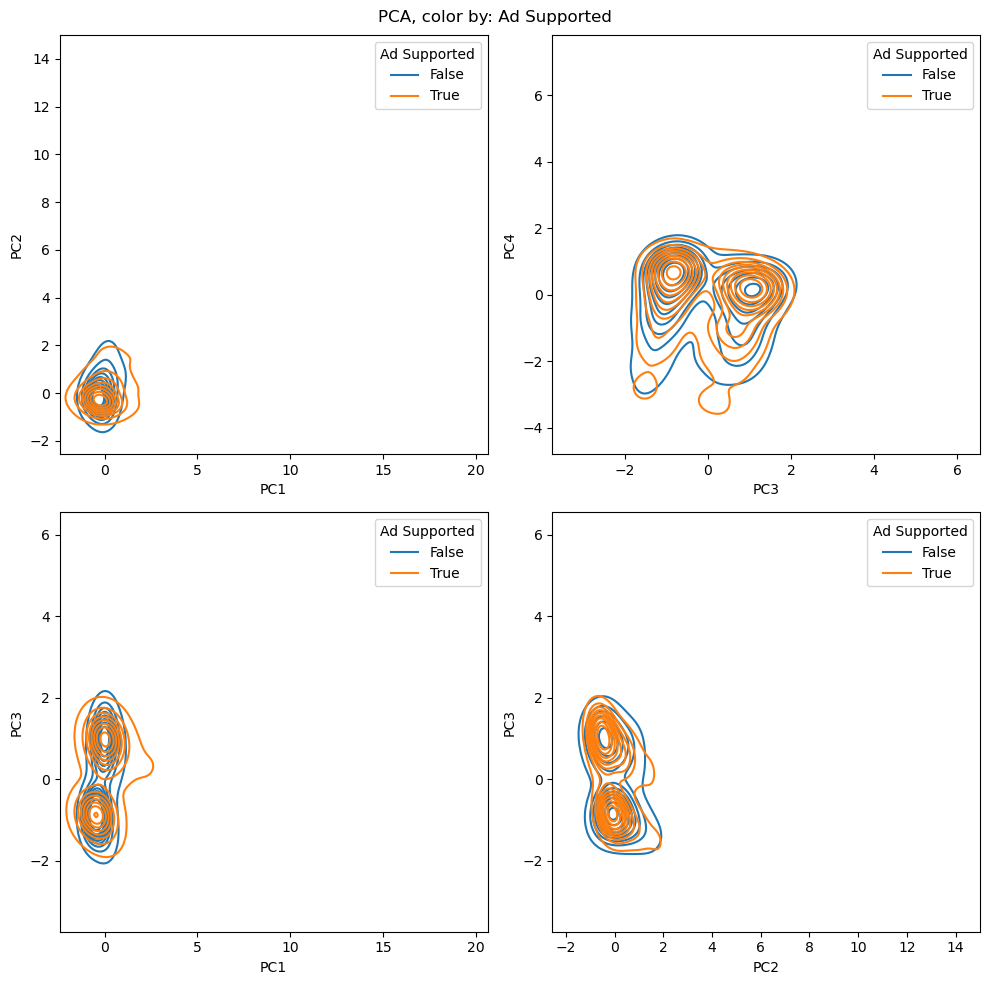

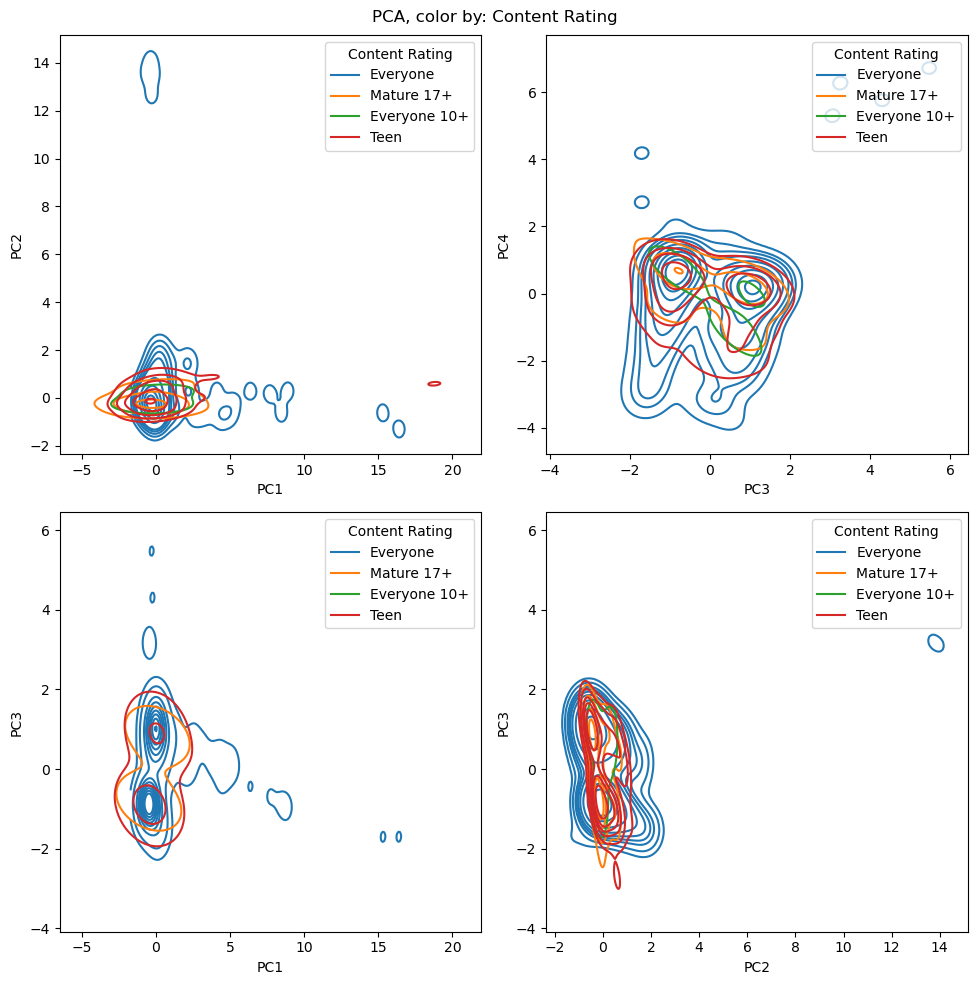

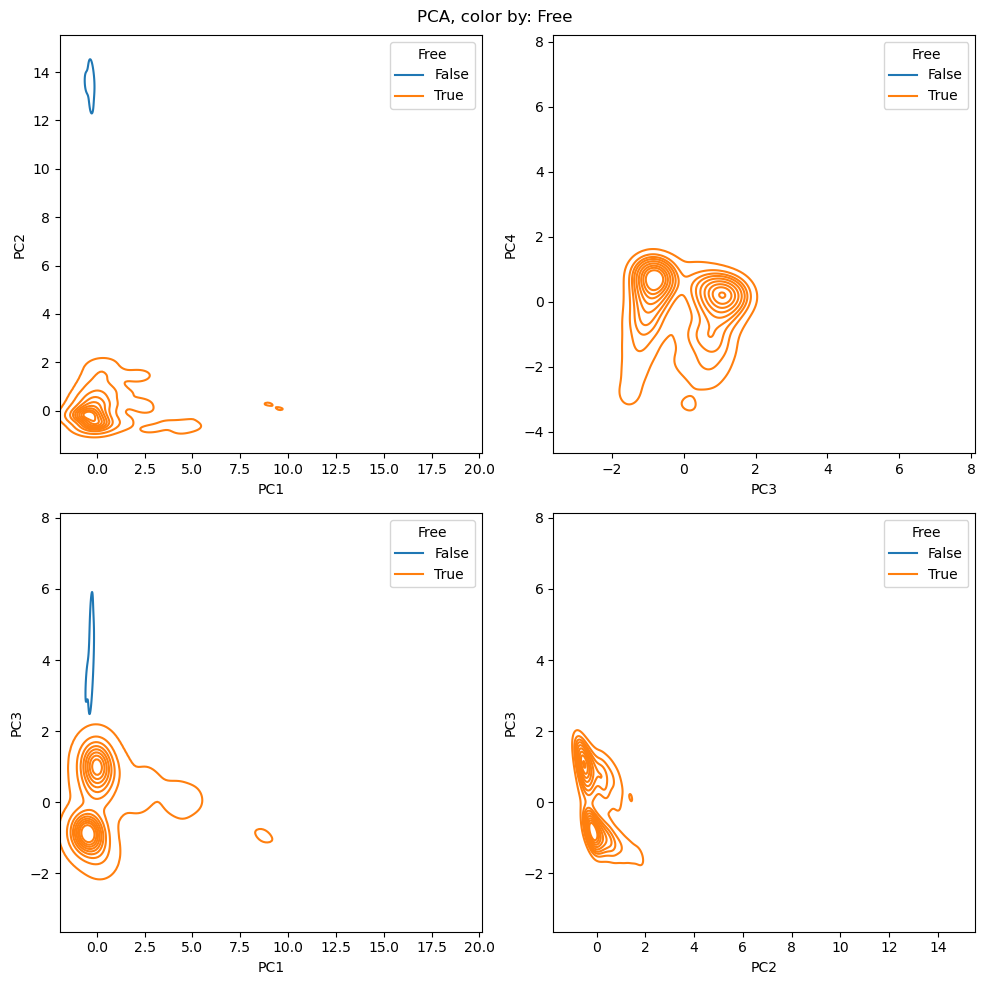

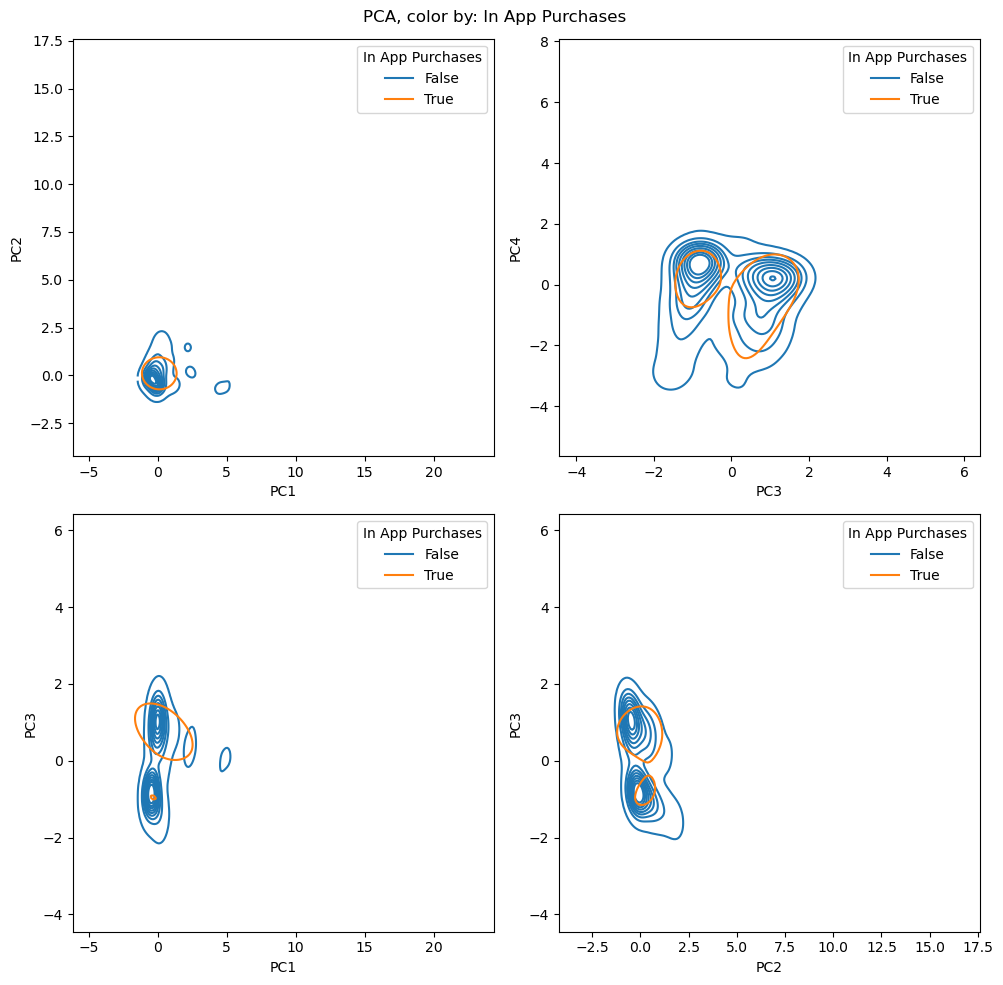

In [37]:
pcs_oi = [[1,2], [3,4], [1,3], [2,3]]
for cat_var_oi in cat_columns:
    unique_cat_values = len(cat_df[cat_var_oi].value_counts())
    print(cat_var_oi, 'unique values: ', unique_cat_values)
    if 1 < unique_cat_values < 11: #this needs to be extended, e.g. to 10 colors by making a predefined colormap
        pca_fig, axs = plt.subplots(nrows = len(pcs_oi)//2, ncols=2, figsize=(10, 10))
        for i in range(len(pcs_oi)):
            sns.kdeplot(ax=axs[i//2, i%2], x = x_pca[:,pcs_oi[i][0]-1], y= x_pca[:,pcs_oi[i][1]-1], hue=cat_df[cat_var_oi])
            #sns.scatterplot(ax=axs[i//2, i%2], x = x_pca[:,pcs_oi[i][0]-1], y= x_pca[:,pcs_oi[i][1]-1], hue=cat_df[cat_var_oi])
            #axs[i//2, i%2].scatter(x_pca[:,pcs_oi[i][0]-1],x_pca[:,pcs_oi[i][1]-1], c=pd.factorize(cat_df[cat_var_oi]), color_map='Viridis')
            axs[i//2, i%2].set_xlabel('PC'+str(pcs_oi[i][0]))
            axs[i//2, i%2].set_ylabel('PC'+str(pcs_oi[i][1]))
        pca_fig.suptitle('PCA, color by: '+ cat_var_oi)
        pca_fig.tight_layout()
        pca_fig.savefig('./outputs/figures/pca_color_by_'+cat_var_oi+'.png')

In [18]:
eng_df.dtypes

App Id               object
Category             object
Rating              float64
Rating Count        float64
Maximum Installs      int64
Free                   bool
Price               float64
Size                float64
Minimum Android      object
Developer Id         object
Released             object
Last Updated         object
Content Rating       object
Ad Supported           bool
In App Purchases       bool
Editors Choice         bool
Scraped Time         object
Size_category        object
dtype: object

In [10]:
pcs_explained_var = pca.explained_variance_
pcs_explained_var_perc = [i / sum(pcs_explained_var) for i in pcs_explained_var]
print(pcs_explained_var_perc)

[0.38810316703868586, 0.20290646999125508, 0.19132569543783357, 0.19082299877883696, 0.0268416687533884]


In [11]:
pd.to_datetime(df['Scraped Time']).dt.date.value_counts()

2021-06-16    1859744
2021-06-15     453200
Name: Scraped Time, dtype: int64